In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,model_from_json,Model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from tensorflow.keras.layers import Dense,Dropout,Flatten,Concatenate,Input
from tensorflow.keras.optimizers import SGD,Adam

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
import datetime
import os, sys
import shutil
import pathlib
import tempfile

### Data Preprocessing

In [26]:
# number of locations
n_train = 441
n_test = 70
n_valid = 63
n_pred = 1

# Image paths
img_train_path = "final data"
train_coords = read_csv(img_train_path + "/Coordinates.csv").values

img_test_path = "final test data"
test_coords = read_csv(img_test_path + "/Coordinates.csv").values

img_valid_path = "final validation data"
valid_coords = read_csv(img_valid_path + "/Coordinates.csv").values

img_pred_path = "99 173"

In [27]:
def preprocss_and_combine_images(n_images,img_path):
    img_list = []

    for i in range(n_images):
        temp_input = []
        temp_output = np.zeros((360,640,3))
        
        for j in range(4):
            img = plt.imread(img_path+"/{}.jpg".format(i*4+j))

            # Scale to [0,1]
            if (img.dtype == np.uint8):
                img = img.astype(float) / 256

            # resize from (360,640,3) to (180,320,3) for combination
            img = cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)),
                            interpolation=cv2.INTER_CUBIC)

            temp_input.append(img)

        # Combine four resized images (-Z,-X,+Z,+X directions) into 
        # one single image (360x640x3) for each coordinate
        temp_output[0:180,0:320] = temp_input[0]         # -Z direction
        temp_output[0:180,320:640] = temp_input[1]       # -X direction
        temp_output[180:360,320:640] = temp_input[2]     # +Z direction
        temp_output[180:360,0:320] = temp_input[3]       # +X direction

        img_list.append(temp_output)

    return np.array(img_list)

In [28]:
# train data
img_train_list = preprocss_and_combine_images(n_train,img_train_path)
img_train_list.shape

(441, 360, 640, 3)

In [29]:
# test data
img_test_list = preprocss_and_combine_images(n_test,img_test_path)
img_test_list.shape

(70, 360, 640, 3)

In [30]:
# validation data
img_valid_list = preprocss_and_combine_images(n_valid,img_valid_path)
img_valid_list.shape

(63, 360, 640, 3)

In [31]:
# prediction data
img_pred_list = preprocss_and_combine_images(n_pred,img_pred_path)
img_pred_list.shape

(1, 360, 640, 3)

In [32]:
# Input image size
img_shape = img_train_list[0].shape
img_shape

(360, 640, 3)

#### Example of an input 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


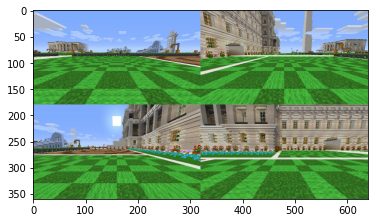

In [27]:
# Display prediction data's input as an example
plt.figure()
plt.imshow(img_pred_list[0])
plt.show()

### Single VGG16 Model 

In [33]:
def single_VGG16(img_shape):
    base_model = VGG16(input_shape=img_shape,include_top=False,weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = False
        
    base_model_input = base_model.input
    base_model_output = base_model.output
    
    flatten = Flatten()(base_model_output)
    dense1 = Dense(128,activation='relu')(flatten)
    dropout = Dropout(0.2)(dense1)
    output = Dense(2)(dropout)
    
    model = Model(inputs=[base_model_input],outputs=[output])
    
    return model

In [34]:
# save checkpoints
checkpoint_path = "single_vgg16_training_finetuning/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# view in tensorboard: tensorboard --logdir logs/fit
log_dir = "tensorboard_logs"
shutil.rmtree(log_dir, ignore_errors=True)

# All callbacks
def get_callbacks():
    return [
        ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,
                        monitor='loss',mode='min',
                        save_weights_only=True,verbose=1),
        #TensorBoard(log_dir=log_dir/name,histogram_freq=1),
        TensorBoard(log_dir=log_dir,histogram_freq=1,
                   write_graph=True,write_images=True),
        EarlyStopping(monitor='loss', patience=3,verbose=2,mode='min'),
    ]

In [35]:
def model_compile_and_fit(model,name,x_train,y_train,optimizer='adam',
                          epochs=10,batch_size=10):
    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])
    history = model.fit(x_train, y_train, 
                        epochs=10, 
                        batch_size=5,
                        callbacks=get_callbacks())
    return history
    

### Model Training

#### Train only the top layer & Freeze all Conv blocks in VGG16

In [36]:
x_train = img_train_list
y_train = train_coords

In [37]:
base_model = VGG16(input_shape=img_shape,include_top=False,weights='imagenet')

# Freeze all Conv blocks in VGG16
for layer in base_model.layers:
    layer.trainable = False
        
base_model_input = base_model.input
base_model_output = base_model.output
    
flatten = Flatten()(base_model_output)
dense1 = Dense(128,activation='relu')(flatten)
dropout = Dropout(0.2)(dense1)
output = Dense(2)(dropout)
    
model = Model(inputs=[base_model_input],outputs=[output])

In [38]:
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])

history = model.fit(x_train, y_train, epochs=7, 
                    batch_size=3,callbacks=get_callbacks())

Epoch 1/7
  1/147 [..............................] - ETA: 0s - loss: 15199.8877 - mean_squared_error: 15199.8877WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
147/147 [==============================] - ETA: 0s - loss: 2333.5312 - mean_squared_error: 2333.5312
Epoch 00001: loss improved from inf to 2333.53125, saving model to single_vgg16_training_finetuning\cp.ckpt
147/147 [==============================] - 741s 5s/step - loss: 2333.5312 - mean_squared_error: 2333.5312
Epoch 2/7
147/147 [==============================] - ETA: 0s - loss: 670.1425 - mean_squared_error: 670.1425
Epoch 00002: loss improved from 2333.53125 to 670.14246, saving model to single_vgg16_training_finetuning\cp.ckpt
147/147 [==============================] - 814s 6s/step -

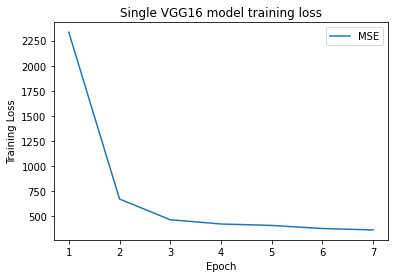

In [40]:
# Training MSE vs Epoch
epoches = np.arange(1,8)

plt.plot(epoches,history.history['loss'],label='MSE')
plt.title('Single VGG16 model training loss')
plt.xticks(epoches)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [41]:
model.save("single_VGG16_model_top_layer.h5")

In [ ]:
#sgd = SGD(lr=0.05, decay=1e-4, momentum=0.9, nesterov=True)

In [42]:
# Test Data MSE
x_test = img_test_list
y_test = test_coords

test_results = model.evaluate(x_test,y_test,verbose=1,batch_size=3)
print("Test MSE: {}".format(test_results[1]))

24/24 [==============================] - 102s 4s/step - loss: 482.6196 - mean_squared_error: 482.6196
Test MSE: 482.61962890625


In [43]:
# Valid Data MSE
x_valid = img_valid_list
y_valid = valid_coords

valid_results = model.evaluate(x_valid,y_valid,verbose=2,batch_size=3)
print("Validation MSE: {}".format(valid_results[1]))

21/21 - 83s - loss: 228.9717 - mean_squared_error: 228.9717
Validation MSE: 228.97169494628906


In [45]:
# Predicted coordinates
x_pred = img_pred_list
y_pred = restored_model.predict(x_pred)[0]
print("Predicted coordinates on (99,173): {}".format(y_pred))

Predicted coordinates on (99,173): [112.23372 189.47255]


In [46]:
# Prediction MSE
y_true = np.array([99,173])
pred_MSE = mean_squared_error(y_true,y_pred)
print("Prediction on (99,173) MSE: {}".format(pred_MSE))

Prediction on (99,173) MSE: 223.23810009402223


#### Model fine-tuning & unfreeze the last Conv block in VGG16

In [44]:
# Unfreeze the last Conv bloack in VGG16, which begins at the 15th layer
last_conv_block_layer = 15
for layer in base_model.layers[last_conv_block_layer:]:
    layer.trainable = True

In [47]:
# Use a small learning rate for the optimizer in fine-tuning
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mean_squared_error'])

history2 = model.fit(x_train, y_train, epochs=4, 
                    batch_size=3,callbacks=get_callbacks())

Epoch 1/4
147/147 [==============================] - ETA: 0s - loss: 523.5515 - mean_squared_error: 523.5515
Epoch 00001: loss improved from inf to 523.55145, saving model to single_vgg16_training_finetuning\cp.ckpt
147/147 [==============================] - 769s 5s/step - loss: 523.5515 - mean_squared_error: 523.5515
Epoch 2/4
147/147 [==============================] - ETA: 0s - loss: 441.4912 - mean_squared_error: 441.4912
Epoch 00002: loss improved from 523.55145 to 441.49118, saving model to single_vgg16_training_finetuning\cp.ckpt
147/147 [==============================] - 763s 5s/step - loss: 441.4912 - mean_squared_error: 441.4912
Epoch 3/4
147/147 [==============================] - ETA: 0s - loss: 350.1705 - mean_squared_error: 350.1705
Epoch 00003: loss improved from 441.49118 to 350.17047, saving model to single_vgg16_training_finetuning\cp.ckpt
147/147 [==============================] - 875s 6s/step - loss: 350.1705 - mean_squared_error: 350.1705
Epoch 4/4
147/147 [=========

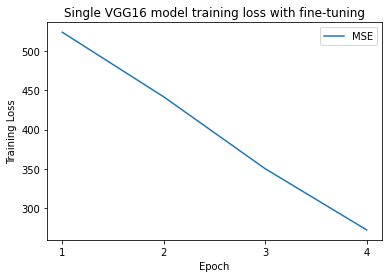

In [49]:
# Training MSE vs Epoch
epoches = np.arange(1,5)

plt.plot(epoches,history2.history['loss'],label='MSE')
plt.title('Single VGG16 model training loss with fine-tuning')
plt.xticks(epoches)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [50]:
model.save("single_VGG16_model_finetuning.h5")

### Restored Final Model

In [51]:
restored_model = single_VGG16(img_shape)
restored_model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])

In [52]:
restored_model.load_weights(checkpoint_path)

In [53]:
restored_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 360, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 160, 128)     

### Final Model Evaluations

In [72]:
restored_model.metrics_names

['loss', 'mean_squared_error']

#### Train data MSE

In [73]:
x_train = img_train_list
y_train = train_coords

In [74]:
# Average Train MSE
train_results = restored_model.evaluate(x_train,y_train,verbose=1,batch_size=3)
print("Train MSE: {}".format(train_results[1]))

147/147 [==============================] - 660s 4s/step - loss: 113.9081 - mean_squared_error: 113.9081
Train MSE: 113.90812683105469


In [75]:
# Train data MSE list
y_train_pred = restored_model.predict(x_train,batch_size=3,verbose=2)

147/147 - 624s


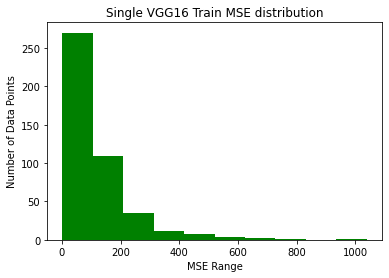

In [76]:
# Train data MSE histogram
train_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_train,y_train_pred)]

plt.hist(train_MSE_list,color='green')
plt.title("Single VGG16 Train MSE distribution")
plt.xlabel("MSE Range")
plt.ylabel("Number of Data Points")
plt.show()

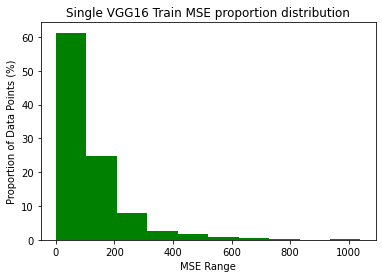

In [77]:
# Train data MSE histogram - Proportion
train_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_train,y_train_pred)]

plt.hist(train_MSE_list,color='green',weights=np.ones_like(train_MSE_list)*100/len(train_MSE_list))
plt.title("Single VGG16 Train MSE proportion distribution")
plt.xlabel("MSE Range")
plt.ylabel("Proportion of Data Points (%)")
plt.show()

#### Test data MSE

In [67]:
x_test = img_test_list
y_test = test_coords

In [68]:
# Average Test MSE
test_results = restored_model.evaluate(x_test,y_test,verbose=1,batch_size=3)
print("Test MSE: {}".format(test_results[1]))

24/24 [==============================] - 102s 4s/step - loss: 323.2581 - mean_squared_error: 323.2581
Test MSE: 323.258056640625


In [69]:
# Test data MSE list
y_test_pred = restored_model.predict(x_test,batch_size=3,verbose=2)

24/24 - 115s


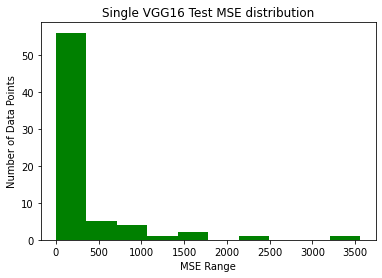

In [70]:
# Test data MSE histogram
test_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_test,y_test_pred)]

plt.hist(test_MSE_list,color='green')
plt.title("Single VGG16 Test MSE distribution")
plt.xlabel("MSE Range")
plt.ylabel("Number of Data Points")
plt.show()

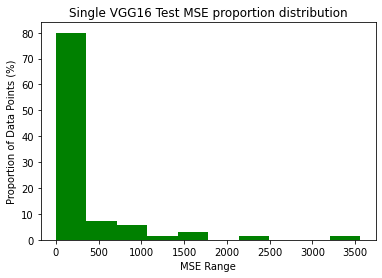

In [71]:
# Test data MSE histogram - Proportion
test_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_test,y_test_pred)]

plt.hist(test_MSE_list,color='green',weights=np.ones_like(test_MSE_list)*100/len(test_MSE_list))
plt.title("Single VGG16 Test MSE proportion distribution")
plt.xlabel("MSE Range")
plt.ylabel("Proportion of Data Points (%)")
plt.show()

#### Validation data MSE

In [60]:
x_valid = img_valid_list
y_valid = valid_coords

In [61]:
# Average Validation MSE
valid_results = restored_model.evaluate(x_valid,y_valid,verbose=2,batch_size=3)
print("Validation MSE: {}".format(valid_results[1]))

21/21 - 83s - loss: 163.5415 - mean_squared_error: 163.5415
Validation MSE: 163.54148864746094


In [62]:
# Validation data MSE list
y_valid_pred = restored_model.predict(x_valid,batch_size=3,verbose=2)

21/21 - 88s


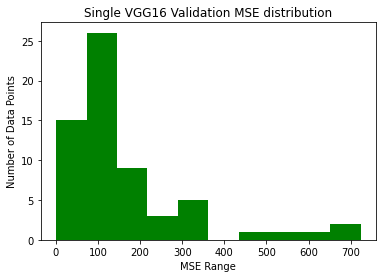

In [65]:
# Validation data MSE histogram
valid_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_valid,y_valid_pred)]

plt.hist(valid_MSE_list,color='green')
plt.title("Single VGG16 Validation MSE distribution")
plt.xlabel("MSE Range")
plt.ylabel("Number of Data Points")
plt.show()

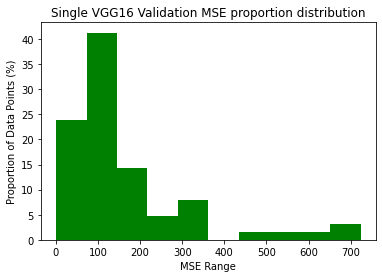

In [66]:
# Validation data MSE histogram - Proportion
valid_MSE_list = [mean_squared_error(y_true,y_pred) for y_true,y_pred in zip(y_valid,y_valid_pred)]

#plt.hist(valid_MSE_list,color='green',density=True,stacked=True)
plt.hist(valid_MSE_list,color='green',weights=np.ones_like(valid_MSE_list)*100/len(valid_MSE_list))
plt.title("Single VGG16 Validation MSE proportion distribution")
plt.xlabel("MSE Range")
plt.ylabel("Proportion of Data Points (%)")
plt.show()

#### Prediction data 

In [80]:
# Predicted coordinates
x_pred = img_pred_list
y_pred = restored_model.predict(x_pred)[0]
print("Predicted coordinates on (99,173): {}".format(y_pred))

Predicted coordinates on (99,173): [ 88.49957 164.63817]


In [81]:
# Prediction MSE
y_true = np.array([99,173])
pred_MSE = mean_squared_error(y_true,y_pred)
print("Prediction on (99,173) MSE: {}".format(pred_MSE))

Prediction on (99,173) MSE: 90.08960057247896
